# Financial Prediction using Machine Learning: Building a trading strategy

In [4]:
# Import Libaries
%load_ext autoreload
%autoreload 2
import workshop_library as wl
from workshop_library.training import training
from workshop_library import financial_backtest
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
fontsize=20
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

## Choose symbol and load data

In [5]:
# Choose from SPY, VXX, MSFT, GLD, AAPL, DAX
symbol = 'SPY'

In [3]:
# load the financial time series data.
df = wl.get_tsymbol(symbol)
df['direction_target'] = (df['ret_1d'] > 0)*1
df = df.drop(['mom_60_ma_100', 'mom_10_ma_100', 'mom_60_ma_200', 'mom_10_ma_200'], axis = 1)
df.dropna(inplace=True)

loaded SPY from ti storage


## Set the Model and Training parameters

In [9]:
# Run 1: Loop over all assets for the Standard RF Classifier and logistic regression and MLPC

for symbol in ['SPY', 'VXX', 'MSFT', 'GLD', 'AAPL', 'DAX']:
    df = wl.get_tsymbol(symbol)
    df['direction_target'] = (df['ret_1d'] > 0)*1
    df = df.drop(['mom_60_ma_100', 'mom_10_ma_100', 'mom_60_ma_200', 'mom_10_ma_200'], axis = 1)
    df.dropna(inplace=True)
    
    backtest_settings = {
    'backtest_method': 'walk_forward_rolling',#'simple_split', #walk_forward_rolling, walk_forward_extending
    'training_window': 1000, #number of days that are used for the training in a rolling or extending procedure
    'step_size': 10, #number of days the training frame is shifted forward in each iteration
    'test_train_diff_days': 1 #time gap between training and test
    }

    model1 =  RandomForestClassifier(
    n_estimators=1000, 
    max_depth=3, 
    min_samples_leaf = .08, 
    random_state=42,
    n_jobs = -1,
    )

    model3 = MLPClassifier(hidden_layer_sizes=(20,6,2), )
    
    model2 = LogisticRegression()
    
    target = 'direction_target'
    risk_free_interest = .02 #
    is_regr_class = 'class' #'class'
    transaction_cost_in_bp = 1
    
    result1 = training(
    df=df,
    model=model1,
    backtest_settings=backtest_settings,
    date_column='Date',
    target=target,
    hide_columns=['ret_10d', 'target', 'ret_1d', 'ret_20d', 'direction_target', 'vola_target']
    )
        
        
    result2 = training(
    df=df,
    model=model2,
    backtest_settings=backtest_settings,
    date_column='Date',
    target=target,
    hide_columns=['ret_10d', 'target', 'ret_1d', 'ret_20d', 'direction_target', 'vola_target']
    )
        
    result3 = training(
    df=df,
    model=model3,
    backtest_settings=backtest_settings,
    date_column='Date',
    target=target,
    hide_columns=['ret_10d', 'target', 'ret_1d', 'ret_20d', 'direction_target', 'vola_target']
)

loaded SPY from ti storage
Load Model from Store
Load Model from Store
Load Model from Store
loaded VXX from ti storage
Load Model from Store
Load Model from Store
Load Model from Store
loaded MSFT from ti storage
Load Model from Store
Load Model from Store
Load Model from Store
loaded GLD from ti storage
Load Model from Store
Load Model from Store
Load Model from Store
loaded AAPL from ti storage
Load Model from Store
Load Model from Store
Load Model from Store
loaded DAX from ti storage
Load Model from Store
Load Model from Store
Load Model from Store


In [ ]:
# Exectue the model training
result1 = training(
    df=df,
    model=model1,
    backtest_settings=backtest_settings,
    date_column='Date',
    target=target,
    hide_columns=['ret_10d', 'target', 'ret_1d', 'ret_20d', 'direction_target', 'vola_target']
)

## Evaluate the correctness of linear regression results

In [8]:
# Calculate the directional_correctness
result1 = result1.join(df['ret_1d'])
direction_correct_ratio = ((result1['prediction']>.5) == (result1['truth'])).mean()
print('Directional Correctness: %1.1f %%' % ( direction_correct_ratio* 100))

weighted_hit_ratio = ((result1['prediction']>.5) == result1['truth']).multiply(result1['ret_1d']).abs().mean()*10000

#print('Weighted Hit Ratio: %1.1f %%' % ( weighted_hit_ratio))
#print('Average Truth: %1.1f %%' % (result['truth'].mean()*100))
#print('Average Long Signal: %1.1f %%' % ((result['prediction']>.5).mean()*100))

Directional Correctness: 53.5 %


## Run a financial backtest with the trained model

In [14]:
# define the logic that translates a prediction into a trading signal
def prediction_to_trading_signal(prediction):
    return np.where(np.abs(prediction-0.5) > .05, (prediction>0.5)*2-1, 0)

Sharpe Ratio: 0.45
Annual Return: 5.76 %


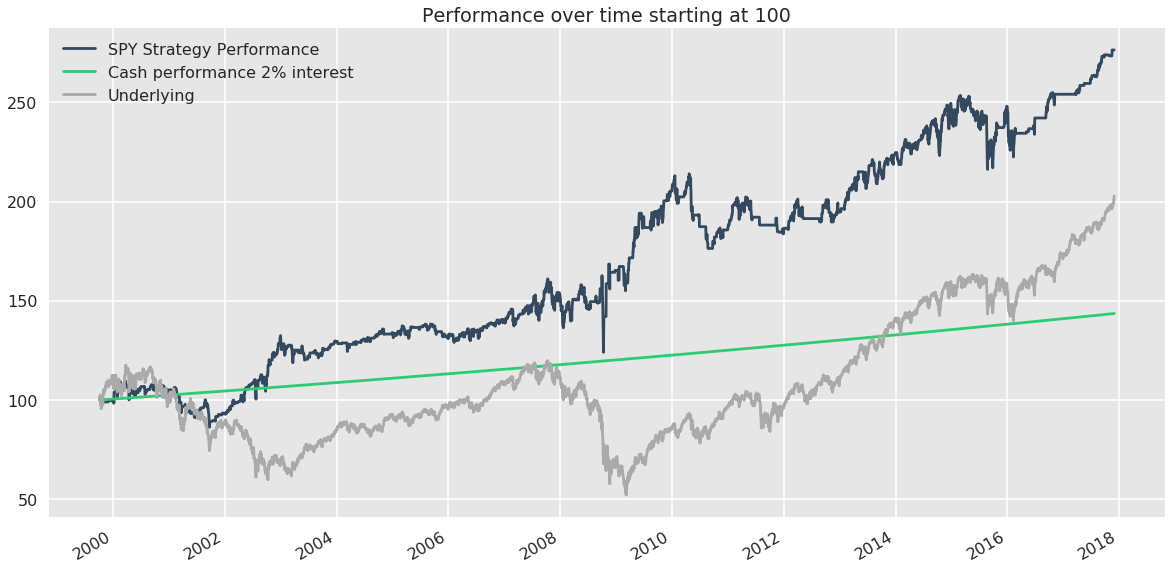

In [15]:
# Run a financial backtest
result = result1
fig = plt.figure(figsize = (20, 10))
trading_signal = prediction_to_trading_signal(result['prediction'])
fb = financial_backtest.SimpleBacktest(prediction_series=result['prediction'], trading_signal=trading_signal, underlying_series=df['close'], is_regr_class= is_regr_class, transaction_cost_in_bp=transaction_cost_in_bp)
ax = fb.performance.plot(title = 'Performance over time starting at 100', label = symbol + ' Strategy Performance');
ax.plot(fb.performance.index, 100*np.cumprod(pd.Series([np.power(1+risk_free_interest, 1/250)] * fb.performance.shape[0])), label = 'Cash performance 2% interest')
ax.plot(fb.performance.index, pd.Series(1+df.loc[result.index].close.pct_change().fillna(0)).cumprod()*100, color = '#AAAAAA', label = 'Underlying',)
ax.legend()
print('Sharpe Ratio: %1.2f' % fb.sharpe_ratio)
print('Annual Return: %1.2f %%' % (100*fb.return_per_annum))

## Run another model to compare their performances

In [9]:
# Execute s second model on logistic regression: Ceteris Paribus, just another model
result2 = training(
    df=df,
    model=model2,
    backtest_settings=backtest_settings,
    date_column='Date',
    target=target,
    hide_columns=['ret_10d', 'target', 'ret_1d', 'ret_20d', 'direction_target', 'vola_target']
)

Load Model from Store


Sharpe Ratio: 0.16
Annual Return: 3.13 %


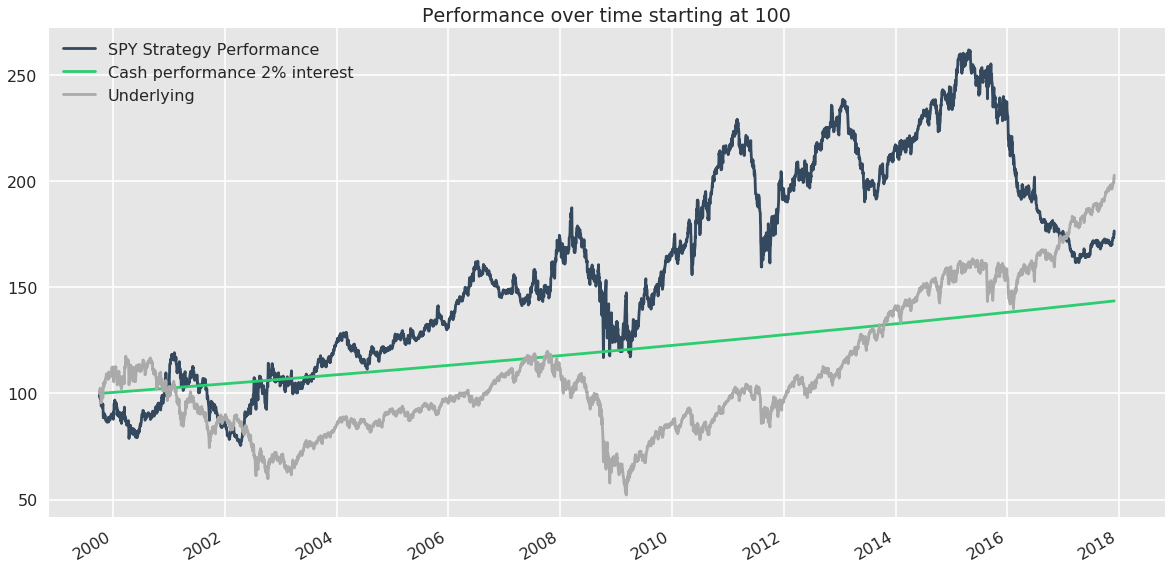

In [10]:
# Run a financial backtest on second model
result = result2
fig = plt.figure(figsize = (20, 10))
trading_signal = prediction_to_trading_signal(result['prediction'])
fb = financial_backtest.SimpleBacktest(prediction_series=result['prediction'], trading_signal=trading_signal, underlying_series=df['close'], is_regr_class= is_regr_class, transaction_cost_in_bp=transaction_cost_in_bp)
ax = fb.performance.plot(title = 'Performance over time starting at 100', label = symbol + ' Strategy Performance');
ax.plot(fb.performance.index, 100*np.cumprod(pd.Series([np.power(1+risk_free_interest, 1/250)] * fb.performance.shape[0])), label = 'Cash performance 2% interest')
ax.plot(fb.performance.index, pd.Series(1+df.loc[result.index].close.pct_change().fillna(0)).cumprod()*100, color = '#AAAAAA', label = 'Underlying',)
ax.legend()
print('Sharpe Ratio: %1.2f' % fb.sharpe_ratio)
print('Annual Return: %1.2f %%' % (100*fb.return_per_annum))